# Homework 3

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

#### Notation Commands

$$\newcommand{\cpn}{\text{c}}$$
$$\newcommand{\Tunder}{T_\text{bond}}$$
$$\newcommand{\accint}{\xi}$$
$$\newcommand{\convert}{\psi}$$
$$\newcommand{\ctd}{\text{ctd}}$$

$$\newcommand{\refrate}{r^{\text{ref}}}$$
$$\newcommand{\pfwd}{P_{\text{fwd}}}$$
$$\newcommand{\grossbasis}{B}$$
$$\newcommand{\netbasis}{\tilde{\grossbasis}}$$
$$\newcommand{\pnl}{\Pi}$$

$$\newcommand{\years}{\tau}$$
$$\newcommand{\yearsACT}{\years_{\text{act/360}}}$$

$$\newcommand{\fwdprice}{\mathcal{F}_{t\to T}}$$
$$\newcommand{\futprice}{F_{t\to T}}$$

$$\newcommand{\fwdpriceT}{\mathcal{F}_{T\to T}}$$
$$\newcommand{\futpriceT}{F_{T\to T}}$$

$$\newcommand{\fwdpriceDT}{\mathcal{F}_{t+h\to T}}$$
$$\newcommand{\futpriceDT}{F_{t+h\to T}}$$

$$\newcommand{\rrepo}{r^{\text{repo}}}$$
$$\newcommand{\carry}{\widetilde{\cpn}}$$

In [23]:
import pandas as pd
import numpy as np

***

# 1. Trading Bonds

### Data

The file `data/fut_bond_data_TYZ4_2024-08-01.xlsx` has market data on the following:
* 10-year Treasury future, expiring December 2024
* The specifications of the deliverable treasury bonds

Suppose the present date is `2024-08-01`.

In [24]:
DATE = '2024-08-01'
futtick = 'TYZ4'


FREQ = 52
FACE = 100

## Load Market Data
futdata = pd.read_excel(f'../Data/fut_bond_data_{futtick}_{DATE}.xlsx', sheet_name=f'future').set_index('field').iloc[:,0]
futdata

field
last_update_dt         2024-08-02 00:00:00
px_last                         114.234375
last_tradeable_dt      2024-12-19 00:00:00
fut_dlv_dt_last        2024-12-31 00:00:00
fut_days_expire                        139
fut_ctd                    T 4.25 06/30/31
fut_ctd_px                      103.296875
fut_ctd_gross_basis               -9.67291
fut_ctd_net_basis                 2.684063
Name: TYZ4 Comdty, dtype: object

In [25]:
bonddata = pd.read_excel(f'../data/fut_bond_data_{futtick}_{DATE}.xlsx', sheet_name=f'bonds').set_index('ticker')
bondtab = bonddata[['maturity','px_last','cpn','conversion']]
bondtab.style.format({'px_last':'{:.2f}','cpn':'{:.2f}','conversion':'{:.4f}','maturity':'{:%Y-%m-%d}'})

,maturity,px_last,cpn,conversion
ticker,,,,
91282CCS Govt,2031-08-15,84.84,1.25,0.7474
91282CDJ Govt,2031-11-15,85.06,1.38,0.7463
91282CDY Govt,2032-02-15,87.80,1.88,0.7670
91282CEP Govt,2032-05-15,94.08,2.88,0.8184
91282CFF Govt,2032-08-15,93.00,2.75,0.8060
91282CFV Govt,2032-11-15,102.53,4.12,0.8851
91282CKW Govt,2031-06-30,103.30,4.25,0.9069
91282CLD Govt,2031-07-31,102.55,4.12,0.9003


In [26]:
bonddata

,last_update_dt,px_last,maturity,days_to_mty,dur_adj_mid,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
ticker,,,,,,,,,,,,,,,
91282CCS Govt,2024-08-02,84.843750,2031-08-15,2566,6.550426,1.250,2024-08-15,10,0.590659,182,172,46.253746,3.646209,5.375,0.7474
91282CDJ Govt,2024-08-02,85.062500,2031-11-15,2658,6.763513,1.375,2024-11-15,102,0.306386,184,82,55.779000,3.623413,5.375,0.7463
91282CDY Govt,2024-08-02,87.796875,2032-02-15,2750,6.816994,1.875,2024-08-15,10,0.885989,182,172,65.717750,3.675354,5.375,0.7670
91282CEP Govt,2024-08-02,94.078125,2032-05-15,2840,6.820612,2.875,2024-11-15,102,0.640625,184,82,75.048750,3.644107,5.375,0.8184
91282CFF Govt,2024-08-02,93.000000,2032-08-15,2932,6.990905,2.750,2024-08-15,10,1.299451,182,172,86.003250,3.692673,5.375,0.8060
91282CFV Govt,2024-08-02,102.531250,2032-11-15,3024,6.921134,4.125,2024-11-15,102,0.919158,184,82,NaN,3.649617,5.375,0.8851
91282CKW Govt,2024-08-02,103.296875,2031-06-30,2520,5.937053,4.250,2024-12-31,148,0.415761,184,36,43.819996,3.590292,5.375,0.9069
91282CLD Govt,2024-08-02,102.546875,2031-07-31,2551,6.038217,4.125,2025-01-31,179,0.056046,184,5,44.961746,3.594133,5.375,0.9003


### 1.1
For each bond, calculate the 
* gross basis
* carry
* net basis 

Your calculations will be more accurate if you consider that it takes time for any trade to "settle". Assume it takes one day.

#### Tip: Calculate Gross Basis using Conversion Factor

$$\underbrace{\grossbasis_{t,t+\tau}^i}_{\text{gross basis}}=\;  P_t^i - \convert^i\futprice$$

where $\convert$ denotes the **conversion factor** which is defined for each bond. You can find the conversion factor in the `conversion` column of the `bonds` sheet of the data.

Why the use of a conversion factor?
* The deliverable bonds differ in maturity and coupon, and thus range in value.
* To account for this, CBOT uses a **conversion factor** such that the futures price at delivery for bond $i$ is
$$\futpriceT\convert^i$$


#### Tip: Calculate Net Basis as Gross Basis Minus Carry

$$\begin{align*}
\text{net basis} \equiv \netbasis^i_{t,T} =& \grossbasis^i_{t,T} - \left(\cpn N - \rrepo P_t^{i,\text{dirty}}\right)\yearsACT\\
=& \grossbasis^i_{t,T} - \left[\cpn N - \rrepo \left(P_t^{i} + \accint_t^i\right)\right]\yearsACT
\end{align*}$$

recalling that
* $N$ denotes the notional, (here face value of 100)
* $\accint$ denotes accrued interest
* $\rrepo$ denotes the repo rate
* $\yearsACT$ denotes the time interval quoted as ACT/360

In [5]:
px = bonddata['px_last']

tab = bonddata[['px_last','conversion']].copy().rename(columns={'px_last':'bond price'})
tab['futures price'] = futdata.loc['px_last']
tab['futures invoice'] = tab['futures price'] * tab['conversion']
tab['gross basis'] = (tab['bond price'] - tab['futures invoice'])
tab['gross basis 32nds'] = tab['gross basis'] * 32
tab.style.format('{:.2f}')

,bond price,conversion,futures price,futures invoice,gross basis,gross basis 32nds
ticker,,,,,,
91282CCS Govt,84.84,0.75,114.23,85.38,-0.54,-17.12
91282CDJ Govt,85.06,0.75,114.23,85.25,-0.19,-6.10
91282CDY Govt,87.80,0.77,114.23,87.62,0.18,5.73
91282CEP Govt,94.08,0.82,114.23,93.49,0.59,18.84
91282CFF Govt,93.00,0.81,114.23,92.07,0.93,29.67
91282CFV Govt,102.53,0.89,114.23,101.11,1.42,45.52
91282CKW Govt,103.30,0.91,114.23,103.60,-0.30,-9.67
91282CLD Govt,102.55,0.90,114.23,102.85,-0.30,-9.55


In [6]:
gross_basis = (px - futdata.loc['px_last'] * bonddata['conversion']).to_frame().rename(columns={0:'dollars'})
gross_basis['32nds'] = gross_basis * 32
gross_basis.columns.name = 'gross basis'

days_settle = 1

cpn = bonddata['cpn']/100
repo = bonddata['repo_reporate']/100

days_fwd = futdata.loc['fut_days_expire'] - days_settle
days_cpn_period = bonddata['accrued_days_between_cpn_dates']
days_already_accrued = bonddata['days_acc'] + days_settle

int_already_acc = cpn*FACE/2 * (days_already_accrued / days_cpn_period)
pxdirty = px + int_already_acc

carry = ((FACE * cpn - repo * pxdirty) * days_fwd / 360).to_frame().rename(columns={0:'dollars'})
carry['32nds'] = carry * 32
net_basis = gross_basis - carry
net_basis.columns.name = 'net basis'


In [7]:
tabnet = bonddata[['cpn','repo_reporate']].copy()

tabnet['days fwd'] = days_fwd
tabnet['accrued int'] = int_already_acc
tabnet['dirty price'] = pxdirty
tabnet['carry'] = carry['dollars']
tabnet['gross basis'] = tab['gross basis']
tabnet['net basis'] = tabnet['gross basis'] - tabnet['carry']
tabnet['net basis (32nds)'] = tabnet['net basis'] * 32
tabnet.style.format('{:.2f}')

,cpn,repo_reporate,days fwd,accrued int,dirty price,carry,gross basis,net basis,net basis (32nds)
ticker,,,,,,,,,
91282CCS Govt,1.25,5.38,138.00,0.59,85.44,-1.28,-0.54,0.75,23.88
91282CDJ Govt,1.38,5.38,138.00,0.31,85.37,-1.23,-0.19,1.04,33.32
91282CDY Govt,1.88,5.38,138.00,0.89,88.69,-1.11,0.18,1.29,41.21
91282CEP Govt,2.88,5.38,138.00,0.65,94.73,-0.85,0.59,1.44,46.03
91282CFF Govt,2.75,5.38,138.00,1.31,94.31,-0.89,0.93,1.82,58.11
91282CFV Govt,4.12,5.38,138.00,0.93,103.46,-0.55,1.42,1.97,63.13
91282CKW Govt,4.25,5.38,138.00,0.43,103.72,-0.51,-0.30,0.21,6.58
91282CLD Govt,4.12,5.38,138.00,0.07,102.61,-0.53,-0.30,0.23,7.51


In [8]:
tabnet[['net basis']]

,net basis
ticker,
91282CCS Govt,0.746187
91282CDJ Govt,1.041334
91282CDY Govt,1.287702
91282CEP Govt,1.438391
91282CFF Govt,1.816044
91282CFV Govt,1.972895
91282CKW Govt,0.205704
91282CLD Govt,0.234696


### 1.2.
If you were required to put on a position today
* long one of the bonds
* short the future

which would you choose based on the data provided in the spreadsheet?

 taking a position in 91282CKW Govt or 91282CLD Govt as they have the lowest net basis values, indicating they are potentially more favorable in terms of cost and pricing relative to the futures market

### 1.3.

Calculate the conversion factor for each bond. Report it to `6` decimal places.

Do they match the conversion factor provided by Bloomberg?


#### Tip: Calculating the Conversion Factor

CBOT calculates the conversion for any bond as the discounted cashflows of the bond, where every cashflow is discounted by 6\%.
* Yes, this conversion factor formula always uses 6\%, regardless of actual interest rates.

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime


# Constants
discount_rate = 0.06  # 6% annual discount rate
face_value = 1  # Assuming face value is 100 for simplicity

# Function to calculate conversion factor for each bond
def calculate_conversion_factor(bond_row):
    # Extract bond data
    cpn = bond_row['cpn'] / 100  # Convert percentage to decimal
    maturity_date = pd.to_datetime(bond_row['maturity'])
    last_update_date = pd.to_datetime(bond_row['last_update_dt'])
    next_coupon_date = pd.to_datetime(bond_row['nxt_cpn_dt'])
    
    # Calculate cashflows (coupon and principal payments)
    cashflows = []
    
    # Calculate coupon payments
    current_date = next_coupon_date
    while current_date < maturity_date:
        # Coupon payment at the current date
        cashflows.append(cpn * face_value*0.5)
        # Move to the next coupon date (assuming semi-annual payments)
        current_date = current_date + pd.DateOffset(months=6)
    
    # Add the principal payment at maturity
    cashflows.append(face_value)
    
    # Discount each cash flow to the last update date
    discounted_cashflows = []
    for cashflow, date in zip(cashflows, [next_coupon_date] + [next_coupon_date + pd.DateOffset(months=6)*i for i in range(1, len(cashflows))]):
        # Calculate the number of years to discount
        years_to_discount = (date - last_update_date).days / 365.25  # Convert days to years
        discounted_cashflow = cashflow / (1 + discount_rate)**years_to_discount
        discounted_cashflows.append(discounted_cashflow)
    
    # The conversion factor is the sum of all discounted cashflows
    conversion_factor = sum(discounted_cashflows)
    return conversion_factor

# Apply the calculation to each bond in the DataFrame
bonddata['conversion_new'] = bonddata.apply(calculate_conversion_factor, axis=1)

# View the results
print(bonddata[['conversion', 'conversion_new']])


               conversion  conversion_new
ticker                                   
91282CCS Govt      0.7474        0.736508
91282CDJ Govt      0.7463        0.732964
91282CDY Govt      0.7670        0.759905
91282CEP Govt      0.8184        0.809695
91282CFF Govt      0.8060        0.804150
91282CFV Govt      0.8851        0.880213
91282CKW Govt      0.9069        0.896455
91282CLD Govt      0.9003        0.885365


The recalculated conversion factors (using the CBOT formula with a 6% discount rate) do not match the conversion factors provided in Bloomberg's dataset. This suggests that Bloomberg might be using a different methodology, possibly adjusting for factors like: Actual market discount rates, Accrued interest adjustments, Different compounding conventions etc

### 1.4 

Calculate the forward price of each bond.

Use the forward prices to do an alternate calculation of net basis, using the formula in the discussion notebook.

Does this calculation agree with the net basis calculation which used gross basis minus carry?


#### Calculate net basis using forward price 

Net basis is also calculated with the same formula as gross basis, but replacing the spot price with the forward price:

$$\text{net basis} \equiv \netbasis^i_{t,T} = \fwdprice^i - \futprice\convert^i$$

recalling that
* $\fwdprice$ denotes the forward price
* $\futprice$ denotes the futures price
* $\convert$ denotes the bond's conversion factor

As we saw in Week 2, no-arbitrage (and frictionless markets) would imply the forward price is exactly the spot price minus carry, in which case this definition would match.

### Forward Price

The forward price is given by the no-arbitrage relationship:

$$\begin{align*}
\text{dirty} \fwdprice =& (P_t^i + \accint_t^i)\left(1+\rrepo_t\, \yearsACT\right)\\
\fwdprice =& (P_t^i + \accint^i_t)\left(1+\rrepo_t\, \yearsACT\right) - \accint_T
\end{align*}$$


#### With interim coupons
If there are interim coupons, the no-arbitrage relationship still holds,
* buy the bond at the dirty price
* simultaneously repo it
* when the coupon pays, use it to reduce the repo balance
* finally, at the terminal date, close out the repo

$$\begin{align*}
\text{dirty} \fwdprice =& \left[(P_t^i + \accint_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right)\\
\fwdprice =& \left[(P^i_t + \accint^i_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right) - \accint^i_T
\end{align*}$$
where
* $\tau_0$ denotes the pre-coupon forward interval, $t_{\text{coupon}}-t$ denoted as ACT/360
* $\tau_1$ denotes the pre-coupon forward interval, $T-t_{\text{coupon}}$ denoted as ACT/360
* note that $\tau=\tau_0+\tau_1$, so the formula is simply splitting the forward interval into pre and post-coupon intervals.

In [10]:
days_settle = 1

tao1 = (futdata.loc['fut_days_expire'] - days_settle -bonddata['days_to_next_coupon'])/360
tao0 = bonddata['days_to_next_coupon'] /360

In [11]:
(pxdirty*(1+repo*tao0 ) -100*cpn/2)*(1+repo*tao1 ) - int_already_acc

ticker
91282CCS Govt     85.969619
91282CDJ Govt     86.137325
91282CDY Govt     88.671332
91282CEP Govt     94.592414
91282CFF Govt     93.544530
91282CFV Govt    102.597873
91282CKW Govt    103.308776
91282CLD Govt    102.594491
dtype: float64

In [12]:
new_df = ((pxdirty*(1+repo*tao0 ) -100*cpn/2)*(1+repo*tao1 ) - int_already_acc).to_frame().rename(columns={0:'forward price'})

new_df['futures price'] = futdata.loc['px_last']
new_df['futures invoice'] = new_df['futures price'] * tab['conversion']

new_df['gross basis'] = (new_df['forward price'] - new_df['futures invoice'])
new_df['net basis'] = new_df['gross basis'] - tabnet['carry']
new_df.style.format('{:.2f}')

,forward price,futures price,futures invoice,gross basis,net basis
ticker,,,,,
91282CCS Govt,85.97,114.23,85.38,0.59,1.87
91282CDJ Govt,86.14,114.23,85.25,0.88,2.12
91282CDY Govt,88.67,114.23,87.62,1.05,2.16
91282CEP Govt,94.59,114.23,93.49,1.10,1.95
91282CFF Govt,93.54,114.23,92.07,1.47,2.36
91282CFV Govt,102.60,114.23,101.11,1.49,2.04
91282CKW Govt,103.31,114.23,103.60,-0.29,0.22
91282CLD Govt,102.59,114.23,102.85,-0.25,0.28


In [28]:
tabnet # from 1.1

,cpn,repo_reporate,days fwd,accrued int,dirty price,carry,gross basis,net basis,net basis (32nds)
ticker,,,,,,,,,
91282CCS Govt,1.250,5.375,138,0.594093,85.437843,-1.281209,-0.535022,0.746187,23.877985
91282CDJ Govt,1.375,5.375,138,0.310122,85.372622,-1.231948,-0.190614,1.041334,33.322699
91282CDY Govt,1.875,5.375,138,0.891140,88.688015,-1.108593,0.179109,1.287702,41.206465
91282CEP Govt,2.875,5.375,138,0.648438,94.726562,-0.849679,0.588712,1.438391,46.028514
91282CFF Govt,2.750,5.375,138,1.307005,94.307005,-0.888951,0.927094,1.816044,58.113419
91282CFV Govt,4.125,5.375,138,0.930367,103.461617,-0.550490,1.422405,1.972895,63.132643
91282CKW Govt,4.250,5.375,138,0.427310,103.724185,-0.507984,-0.302280,0.205704,6.582529
91282CLD Govt,4.125,5.375,138,0.067255,102.614130,-0.533029,-0.298333,0.234696,7.510267


- The net basis values are similar but not identical.
- The differences are small (e.g., for 91282CFV Govt, the difference is only 0.067).
- The largest difference is 1.12 for 91282CCS Govt, but it's still within a reasonable range.

The forward price net basis calculation is close to the gross basis minus carry approach, but there are minor deviations likely due to
rounding differences in Bloomberg data, approximations in the repo rate compounding etc.

***

# 2. Fed Funds Futures

The file `data/fedfutures_2025-01-31.xlsx` has market data on the following:
* Fed Fund Futures Chain out 18 months.
* Dates of upcoming Fed meetings (approximated in 2026.)
* Spot Fed Funds data
* Prices of the futures chain on a historic date.

Suppose the present date is `2024-01-31`.

### 2.1. Chart the Fed Futures Rates

Chart the Fed Funds curve at
* `2025-01-26`
* `2025-01-31`

Note that you are charting the implied Fed Funds Futures *rate*, not price.

Comment on how today's **open interest** varies across the chain.

In [36]:
fedfutures_1 = pd.read_excel(f'../Data/fedfutures_2025-01-31.xlsx', sheet_name='2025-01-26').set_index('last_tradeable_dt')
fedfutures_2 = pd.read_excel(f'../Data/fedfutures_2025-01-31.xlsx', sheet_name='2025-01-31').set_index('last_tradeable_dt')


In [37]:
fedfutures_1['rate'] = 100 - fedfutures_1['px_last']
fedfutures_2['rate'] = 100 - fedfutures_2['px_last']

In [38]:
fedfutures_1.head()

,ticker,px_last,rate
last_tradeable_dt,,,
2025-02-28,FFG5 Comdty,95.675,4.325
2025-03-31,FFH5 Comdty,95.705,4.295
2025-04-30,FFJ5 Comdty,95.755,4.245
2025-05-30,FFK5 Comdty,95.810,4.190
2025-06-30,FFM5 Comdty,95.875,4.125


In [39]:
fedfutures_2.head()

,ticker,px_last,open_int,rate
last_tradeable_dt,,,,
2025-02-28,FFG5 Comdty,95.675,503574,4.325
2025-03-31,FFH5 Comdty,95.690,320421,4.310
2025-04-30,FFJ5 Comdty,95.715,318741,4.285
2025-05-30,FFK5 Comdty,95.770,360361,4.230
2025-06-30,FFM5 Comdty,95.830,156189,4.170


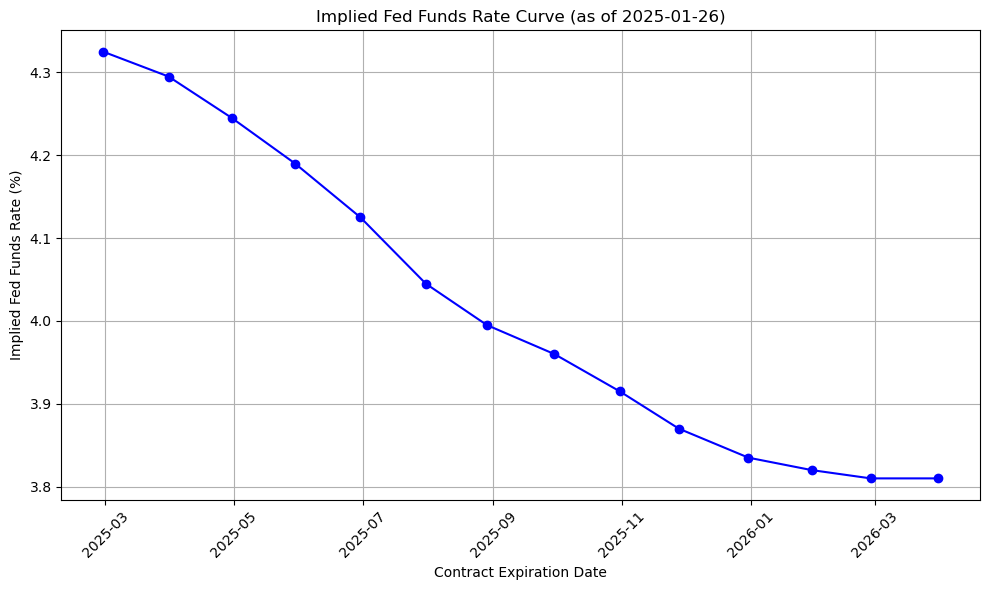

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(fedfutures_1.index, fedfutures_1['rate'], marker='o', linestyle='-', color='b', label="Implied Fed Funds Rate")
plt.title("Implied Fed Funds Rate Curve (as of 2025-01-26)")
plt.xlabel("Contract Expiration Date")
plt.ylabel("Implied Fed Funds Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

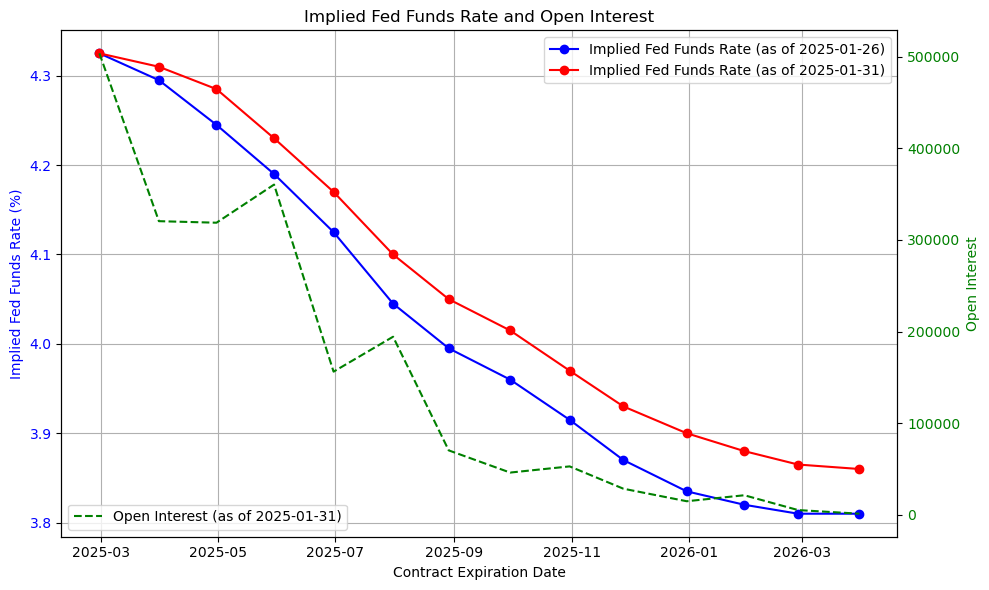

In [41]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(fedfutures_1.index, fedfutures_1['rate'], marker='o', linestyle='-', color='b', label="Implied Fed Funds Rate (as of 2025-01-26)")
ax1.plot(fedfutures_2.index, fedfutures_2['rate'], marker='o', linestyle='-', color='r', label="Implied Fed Funds Rate (as of 2025-01-31)")
ax1.set_xlabel("Contract Expiration Date")
ax1.set_ylabel("Implied Fed Funds Rate (%)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend()
# Create a second y-axis to plot open interest
ax2 = ax1.twinx()
ax2.plot(fedfutures_2.index, fedfutures_2['open_int'], linestyle='--', color='g', label="Open Interest (as of 2025-01-31)")
ax2.set_ylabel("Open Interest", color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc = 'lower left')

# Title and grid
plt.title("Implied Fed Funds Rate and Open Interest")
ax1.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

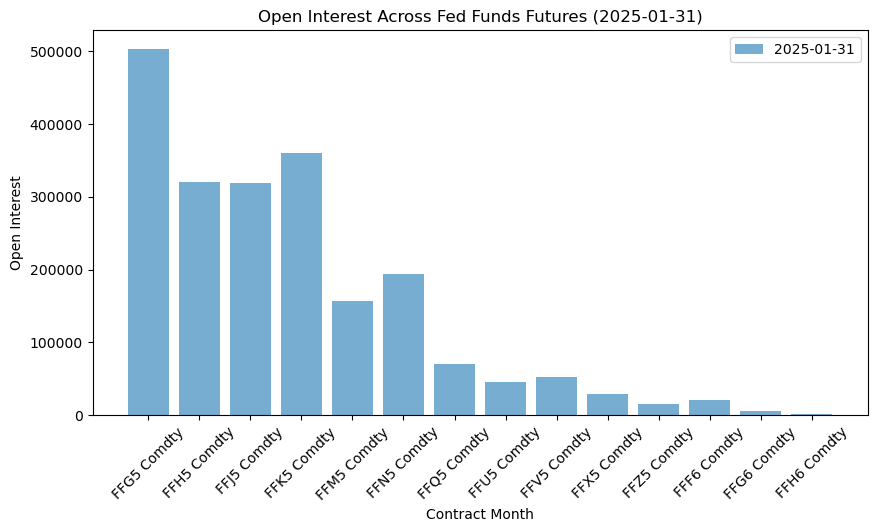

In [46]:
plt.figure(figsize=(10, 5))
# plt.bar(fedfutures_1["ticker"], fedfutures_1["open_int"], alpha=0.6, label="2025-01-26")
plt.bar(fedfutures_2["ticker"], fedfutures_2["open_int"], alpha=0.6, label="2025-01-31")
plt.xlabel("Contract Month")
plt.ylabel("Open Interest")
plt.title("Open Interest Across Fed Funds Futures (2025-01-31)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Fed Funds Implied Rates: The implied rates decline over time, indicating market expectations of potential rate cuts.

Open Interest Analysis:
- Highest open interest is in the near-term contracts.
- Later contracts have lower open interest, suggesting traders are more focused on near-term rate movements.

### 2.2 Extracting the Expected Path of Fed Funds Rates

Assume the Fed...
* sets the rate exactly at its list of meeting dates.
* does not change the rate betweeen meeting dates.

Use the present data to calculate--and plot--the implied set of expected Fed Funds rates as of each meeting date.

#### Technical Point
* Consider months, $t$, where there is a meeting, but such that in month $t+1$ there is no meeting.
* There will be two reasonable ways to extract the expected fed funds rate:
    1. Use the futures rate from the $t+1$-contract
    2. Calculate the implied rate for the remainder of month $t$, knowing the expected rate at the end of month $t+1$.
* These are both reasonable and will likely not differ much.

Try to make reasonable assumptions as needed. to implement the calculation.

In [51]:
meeting_dates = pd.read_excel(f'../Data/fedfutures_2025-01-31.xlsx', sheet_name='fed meetings')
meeting_dates['meeting dates'] = pd.to_datetime(meeting_dates['meeting dates'])


In [52]:
meeting_dates

,meeting dates
0,2025-03-19
1,2025-05-07
2,2025-06-18
3,2025-07-30
4,2025-09-17
5,2025-10-29
6,2025-12-10
7,2026-01-29
8,2026-03-18


In [53]:
rate_df = pd.read_excel(f'../Data/fedfutures_2025-01-31.xlsx', sheet_name='fed funds')
rate_df['date'] = pd.to_datetime(rate_df['date'])


In [58]:
fedfutures_2

,ticker,px_last,open_int,rate
last_tradeable_dt,,,,
2025-02-28,FFG5 Comdty,95.675,503574,4.325
2025-03-31,FFH5 Comdty,95.690,320421,4.310
2025-04-30,FFJ5 Comdty,95.715,318741,4.285
2025-05-30,FFK5 Comdty,95.770,360361,4.230
2025-06-30,FFM5 Comdty,95.830,156189,4.170
2025-07-31,FFN5 Comdty,95.900,194301,4.100
2025-08-29,FFQ5 Comdty,95.950,70271,4.050
2025-09-30,FFU5 Comdty,95.985,46060,4.015
2025-10-31,FFV5 Comdty,96.030,52800,3.970


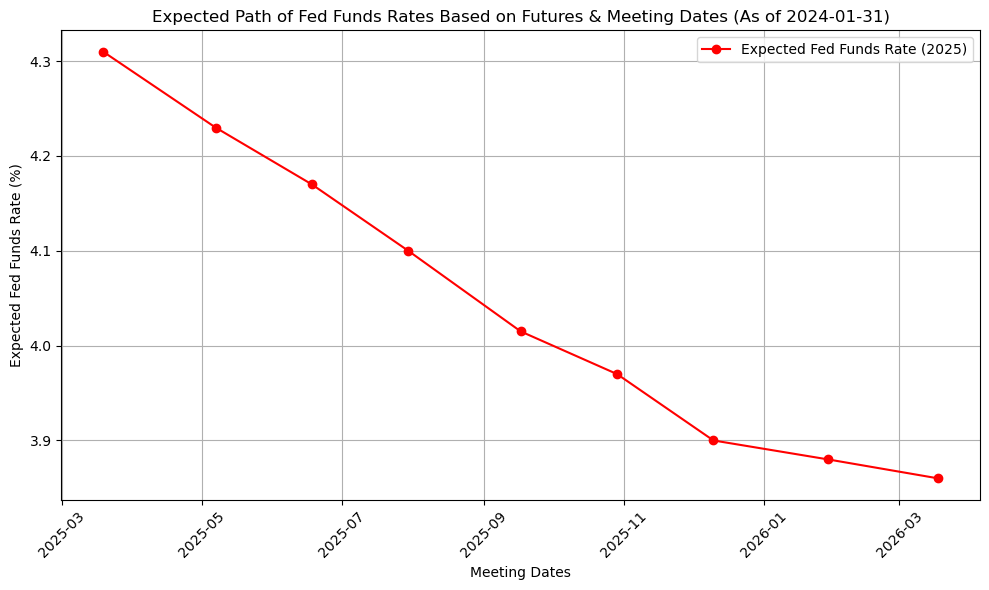

In [59]:
implied_rates_2025 = []
implied_dates_2025 = []

for meeting_date in meeting_dates["meeting dates"].to_list():
    # Find the closest Fed futures rate after the meeting date
    future_data_after_meeting = fedfutures_2[
        fedfutures_2.index >= meeting_date.strftime("%Y-%m-%d")
    ]

    if not future_data_after_meeting.empty:
        implied_rate = 100 - future_data_after_meeting.iloc[0]["px_last"]
    else:
        implied_rate = None  # No available futures data for this meeting

    implied_rates_2025.append(implied_rate)
    implied_dates_2025.append(meeting_date)

# Plot Expected Fed Funds Rate Path (2025) from the 2024-01-31 perspective
plt.figure(figsize=(10, 6))
plt.plot(implied_dates_2025, implied_rates_2025, marker="o", linestyle="-", color="r", label="Expected Fed Funds Rate (2025)")
plt.title("Expected Path of Fed Funds Rates Based on Futures & Meeting Dates (As of 2024-01-31)")
plt.xlabel("Meeting Dates")
plt.ylabel("Expected Fed Funds Rate (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
# implied_rates = []
# implied_dates = []
# for meeting_date in meeting_dates['meeting dates'].to_list():
#     next_month = meeting_date + pd.DateOffset(months=1)
#     next_month_meeting = meeting_dates[meeting_dates['meeting dates'].dt.month == next_month.month]
#     if next_month_meeting.empty:
#         next_future_rate = fedfutures_1[fedfutures_1.index > meeting_date].iloc[0]['rate']
#         implied_rates.append(next_future_rate)
#         implied_dates.append(meeting_date)

# plt.figure(figsize=(10, 6))
# plt.plot(implied_dates, implied_rates, marker='o', linestyle='-', color='b', label="Implied Fed Funds Rate")

# plt.title("Implied Fed Funds Rate Expectations as of Meeting Dates")
# plt.xlabel("Meeting Dates")
# plt.ylabel("Implied Fed Funds Rate (%)")
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Show plot
# plt.legend()
# plt.show()


### 2.3 Compare to the Historic Curve

Use the price data in `2024` to extract the expectations at the previous date.
* Note that you do not need to "bootstrap" up from the historic date to the current date. 

Compare this to the answer in the previous problem, for the current data.

In [66]:
fed_futures_2024=pd.read_excel(f'../Data/fedfutures_2025-01-31.xlsx', sheet_name='2024-07-29')

In [67]:
fed_futures_2024.head()

,ticker,px_last,last_tradeable_dt
0,FFQ4 Comdty,94.6825,2024-08-30
1,FFU4 Comdty,94.7900,2024-09-30
2,FFV4 Comdty,94.9500,2024-10-31
3,FFX4 Comdty,95.0750,2024-11-29
4,FFZ4 Comdty,95.2050,2024-12-31


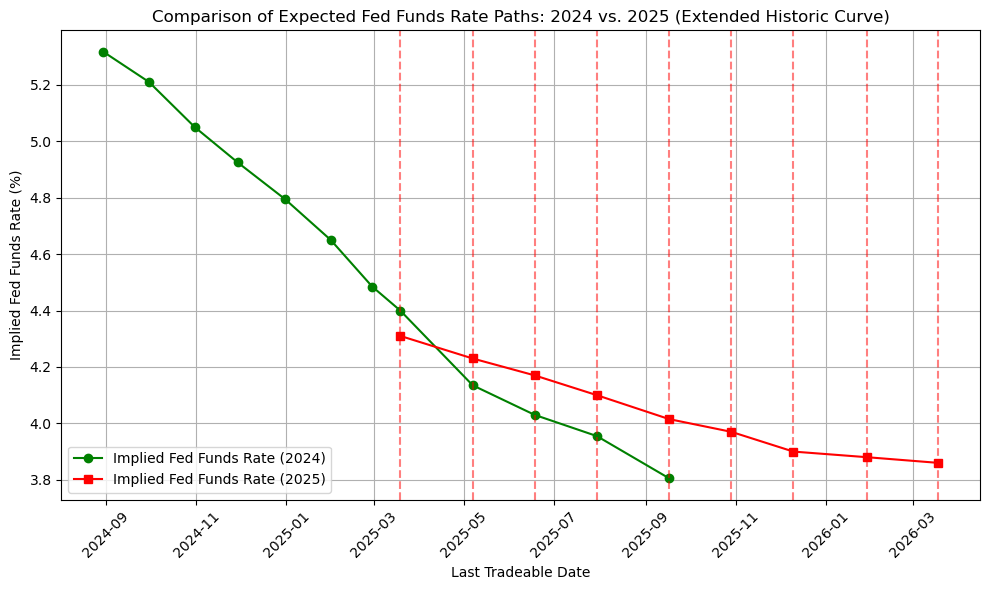

In [69]:
implied_rates_2024 = []
implied_dates_2024 = []

for meeting_date in meeting_dates["meeting dates"].to_list():
    # Find the closest Fed futures rate after the meeting date in 2024
    future_data_after_meeting = fed_futures_2024[
        fed_futures_2024["last_tradeable_dt"] >= meeting_date.strftime("%Y-%m-%d")
    ]

    if not future_data_after_meeting.empty:
        implied_rate = 100 - future_data_after_meeting.iloc[0]["px_last"]
    else:
        implied_rate = None  # No available futures data for this meeting

    implied_rates_2024.append(implied_rate)
    implied_dates_2024.append(meeting_date)

# Extend 2024 curve to include earlier expectations
earlier_futures_2024 = fed_futures_2024[fed_futures_2024["last_tradeable_dt"] < meeting_dates["meeting dates"].min()]
earlier_dates_2024 = pd.to_datetime(earlier_futures_2024["last_tradeable_dt"])
earlier_rates_2024 = 100 - earlier_futures_2024["px_last"]

full_dates_2024 = list(earlier_dates_2024) + implied_dates_2024
full_rates_2024 = list(earlier_rates_2024) + implied_rates_2024

# Plot Comparison of 2024 vs. 2025 Expected Fed Funds Rates
plt.figure(figsize=(10, 6))
plt.plot(full_dates_2024, full_rates_2024, marker="o", linestyle="-", color="g", label="Implied Fed Funds Rate (2024)")
plt.plot(implied_dates_2025, implied_rates_2025, marker="s", linestyle="-", color="r", label="Implied Fed Funds Rate (2025)")

# Mark FOMC Meetings
for date in implied_dates_2025:
    plt.axvline(x=date, color="red", linestyle="--", alpha=0.5)

plt.title("Comparison of Expected Fed Funds Rate Paths: 2024 vs. 2025 (Extended Historic Curve)")
plt.xlabel("Last Tradeable Date")
plt.ylabel("Implied Fed Funds Rate (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

- In 2024, the market expected rate cuts to begin earlier and be more aggressive.
- In 2025, expectations have adjusted downward, implying the Fed will hold rates steady for longer.

***